In [1]:
import numpy as np
import torch
from torch import optim, nn
from collections import OrderedDict
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Initialization

In [2]:
batch_size = 64
print_every = 10
epochs = 10
lr = 0.0001
CRUP_DIMENSION = (224, 224)
MEANS = [0.485, 0.456, 0.406]
STANDARD_DEVIATIONS = [0.229, 0.224, 0.225]

### set Device

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda:0


# Load Data

In [4]:
dataset_dir = 'Datasets/Chest X-Ray/'
train_dir = dataset_dir + 'train/'
test_dir = dataset_dir + 'test/'
valid_dir = dataset_dir + 'val/'

In [5]:
train_transforms = transforms.Compose([
                        transforms.RandomRotation(10),
                        transforms.RandomResizedCrop(CRUP_DIMENSION),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(MEANS, STANDARD_DEVIATIONS)
                    ])
valid_transforms = transforms.Compose([
                        transforms.RandomRotation(10),
                        transforms.RandomResizedCrop(CRUP_DIMENSION),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(MEANS, STANDARD_DEVIATIONS)
                    ])
test_transforms = transforms.Compose([
                        transforms.RandomRotation(10),
                        transforms.RandomResizedCrop(CRUP_DIMENSION),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(MEANS, STANDARD_DEVIATIONS)
                    ])

# Load the Datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)


# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [6]:
train_class_idx = train_dataset.class_to_idx
valid_class_idx = valid_dataset.class_to_idx
test_class_idx = test_dataset.class_to_idx

# Plot Sample Data

In [7]:
def plot_data(tensor, tensor_class_idx, count=1, normalize=True):
    images, labels = next(tensor)
    a = np.floor(count**0.5).astype(int)
    b = np.ceil(1.*count/a).astype(int)
    fig = plt.figure(figsize=(4.*b,4.*a))
    for i in range(1, count+1):
        ax = fig.add_subplot(a,b,i)
        ax.plot(images[i].numpy()[:,0,0])
        forDisplay = images[i].numpy().transpose((1, 2, 0))
        
        if normalize:
            mean = np.array(MEANS)
            standard_deviation = np.array(STANDARD_DEVIATIONS)
            forDisplay = standard_deviation * forDisplay + mean
            forDisplay = np.clip(forDisplay, 0, 1)
        ax.imshow(forDisplay)
        
        ax.set_title({val: key for key, val in tensor_class_idx.items()}[labels[i].item()])
        ax.set_axis_off()

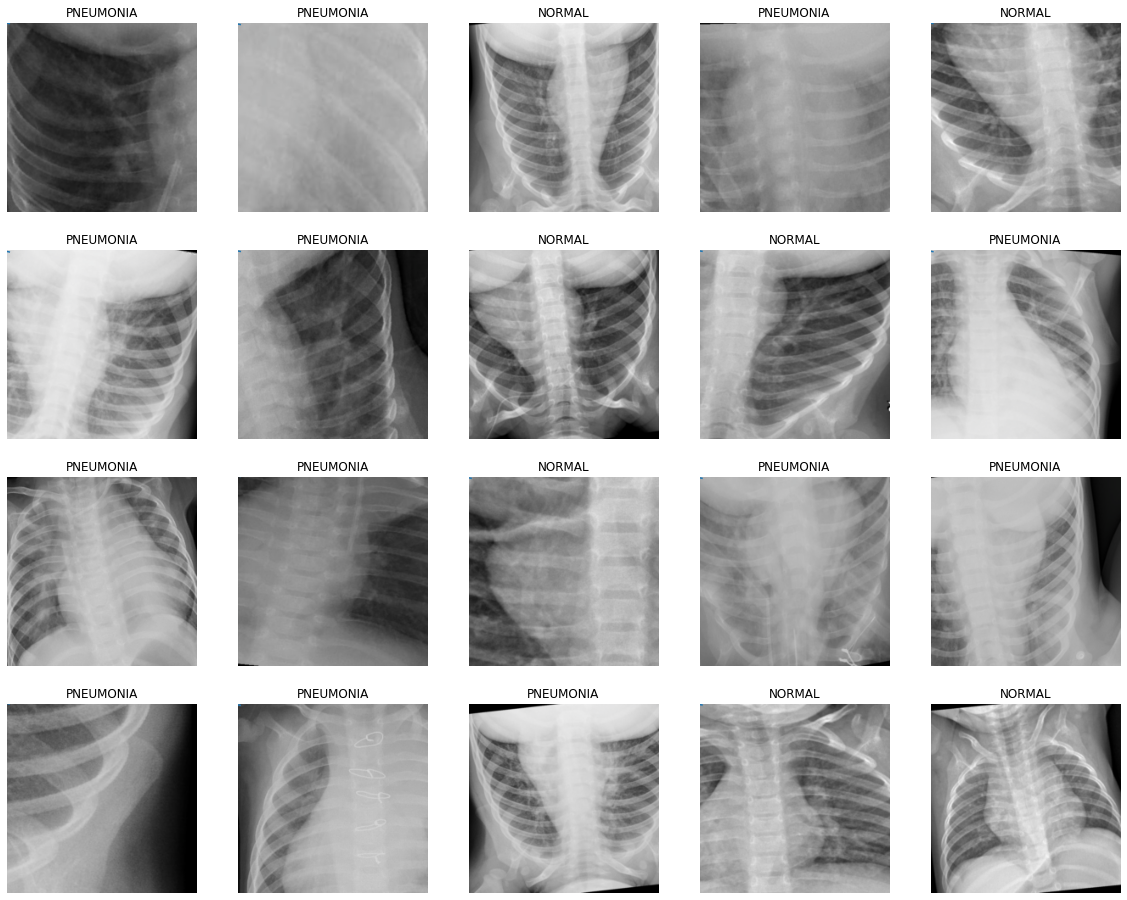

In [8]:
plot_data(iter(train_loader), train_class_idx, count=20)

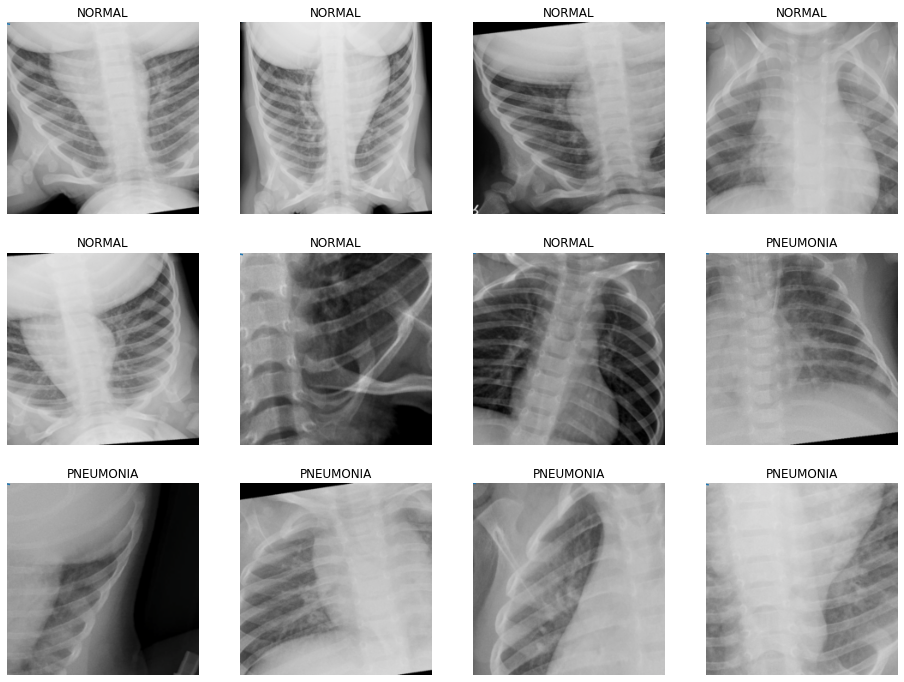

In [9]:
plot_data(iter(valid_loader), valid_class_idx, count=12)

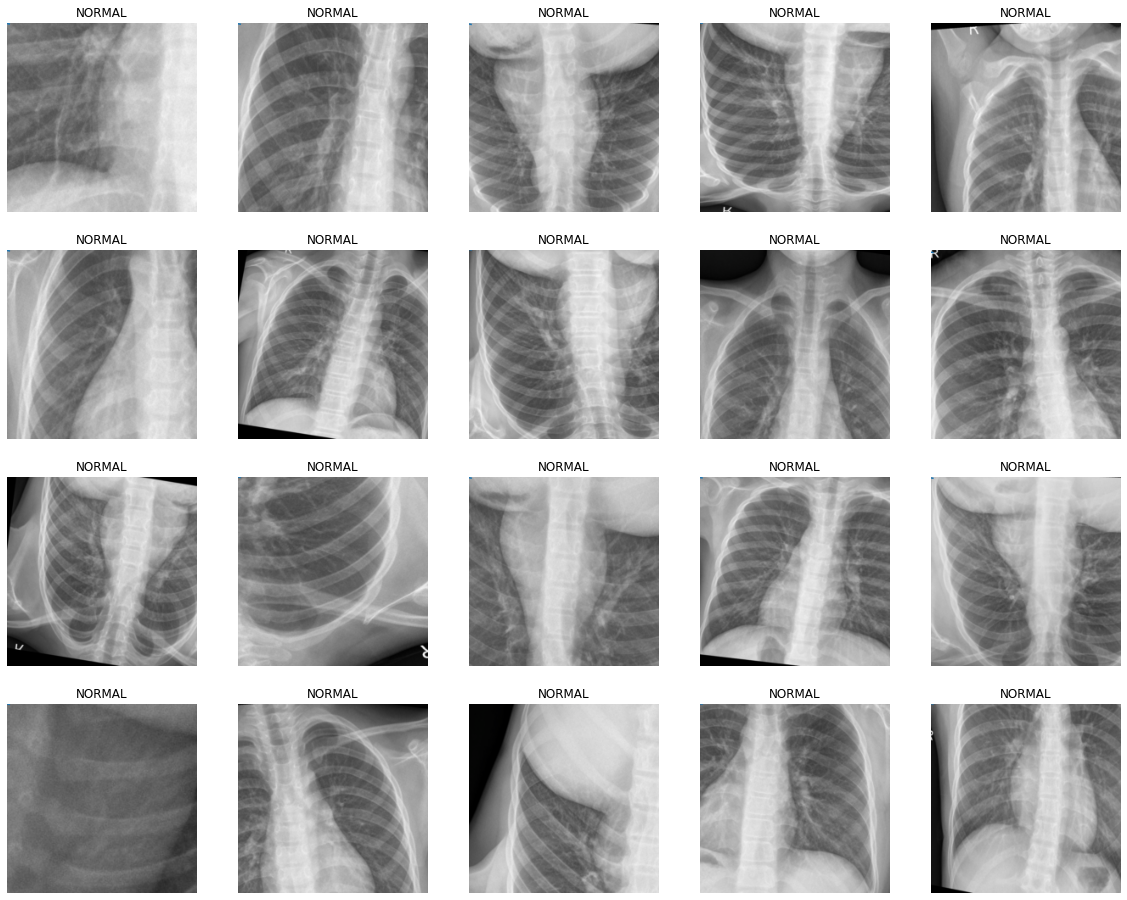

In [10]:
plot_data(iter(test_loader), test_class_idx, count=20)

# Chest X-Ray Model

In [11]:
class Chest_XRay(nn.Module):
    def __init__(self):
        super(Chest_XRay, self).__init__()
        self.features = self._setFeatures()
        self.classifier_in_featuers = 4608#2304 #50176
        self.classifier = self._setClassifier()
        
    def _setFeatures(self):
        return nn.Sequential(OrderedDict([
            ('0', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))),
            ('1', nn.ReLU(inplace=True)),
            ('2', nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0, dilation=1, ceil_mode=False)),
            ('2_5', nn.BatchNorm2d(num_features=64)),
            ('3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))),
            ('4', nn.ReLU(inplace=True)),
            ('5', nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0, dilation=1, ceil_mode=False)),
            ('5_5', nn.BatchNorm2d(num_features=128)),
            ('6', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))),
            ('7', nn.ReLU(inplace=True)),
            ('8', nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0, dilation=1, ceil_mode=False)),
            ('8_5', nn.BatchNorm2d(num_features=256)),
            ('9', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))),
            ('10', nn.ReLU(inplace=True)),
            ('11', nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0, dilation=1, ceil_mode=False)),
            ('11_5', nn.BatchNorm2d(num_features=512)),
            ('12', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))),
            ('13', nn.ReLU(inplace=True)),
            ('14', nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0, dilation=1, ceil_mode=False)),
            ('14_5', nn.BatchNorm2d(num_features=512)),
            ('15', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))),
            ('16', nn.ReLU(inplace=True)),
            ('17', nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0, dilation=1, ceil_mode=False)),
            ('17_5', nn.BatchNorm2d(num_features=512)),
            ('18', nn.Flatten())
        ]))
    
    def _setClassifier(self):
        return nn.Sequential(OrderedDict([
            ('c0', nn.Linear(self.classifier_in_featuers, 512)),
            ('c1', nn.Dropout(p=0.2)),
            ('c2', nn.ReLU()),
            ('c3', nn.Linear(512, 256)),
            ('c4', nn.Dropout(p=0.2)),
            ('c5', nn.ReLU()),
            ('c6', nn.Linear(256, 64)),
            ('c7', nn.Dropout(p=0.2)),
            ('c8', nn.ReLU()),
            ('c9', nn.Linear(64, 20)),
            ('c10', nn.Dropout(p=0.2)),
            ('c11', nn.ReLU()),
            ('c12', nn.Linear(20, 2)),
            ('c13', nn.LogSoftmax(dim=1))
        ]))
    
    def forward(self, X):
        X = self.features(X)
#         print(X.size())
        X = self.classifier(X)
        return X
    
    def trainXRay(self, training_dataset, validation_dataset, loss_function, optimizer, epochs, print_every, device):
        # Set model to appropriate device
        self.to(device)
        
        batch_size = training_dataset.batch_size
        
        # Print training overview messages
        print("Training on %s" % device)
        print("%s batchs of %s images per batch" % (len(training_dataset.batch_sampler) * epochs, batch_size))
        print("Average loss and accuracy will display every %s batches\n" % print_every)
        
        
        train_losses = []
        validation_losses = []
        validation_accuracy = []
        
        for epoch in range(epochs):
            print("Working on Epoch: %s/%s" % (epoch+1, epochs))
            print("---------------------------------------")
            
            epoch_loss = 0
            self.train()
            
            for batch_idx, (inputs, labels) in enumerate(training_dataset):
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Set all optimizer gradients to zero
                optimizer.zero_grad()
                
                # Forward and backward passes
                outputs = self.forward(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss
                if (batch_idx+1) % print_every == 0:
                    print("---------------------------------------")
                    print("Current status Batch %s: Images %s to %s." % ((batch_idx+1), batch_size * 
                                                                      (batch_idx+1), batch_size *
                                                                      ((batch_idx+1) + 1)))
                    validation_correct, validation_total, validation_loss = self.check_neural_network_accuracy(
                                                                                    validation_dataset,
                                                                                    device,
                                                                                    loss_function)
                    train_losses.append(epoch_loss / print_every)
                    validation_losses.append(validation_loss / print_every)
                    validation_accuracy.append((validation_correct / validation_total) * 100)
                    print("Training Loss: {:.3f}".format(epoch_loss / print_every),
                          " - Validation Loss: {:.3f}".format(validation_loss / print_every),
                          " - Validation Accuracy: %d%%" % ((validation_correct / validation_total) * 100))                    
                    epoch_loss = 0
        return train_losses, validation_losses, validation_accuracy
    
    def check_neural_network_accuracy(self, dataset, device, criterion, correct=0, total=0):    
        print("Checking accuracy:")
        loss = 0
        model.to(device)
        model.eval()

        # Check accuracy without calculating gradient
        with torch.no_grad():
            for ii, (inputs, labels) in enumerate(dataset):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                current_loss = criterion(outputs, labels)
                # Update loss for current training
                loss += current_loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        model.train()

        return correct, total, loss

In [12]:
model = Chest_XRay()

# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)



In [13]:
train_losses, validation_losses, validation_accuracy = model.trainXRay(train_loader,
                                                                       valid_loader,
                                                                       loss_function,
                                                                       optimizer,
                                                                       epochs,
                                                                       print_every,
                                                                       device)

Training on cuda:0
820 batchs of 64 images per batch
Average loss and accuracy will display every 10 batches

Working on Epoch: 1/10
---------------------------------------
---------------------------------------
Current status Batch 10: Images 640 to 704.
Checking accuracy:
Training Loss: 0.734  - Validation Loss: 0.069  - Validation Accuracy: 81%
---------------------------------------
Current status Batch 20: Images 1280 to 1344.
Checking accuracy:
Training Loss: 0.576  - Validation Loss: 0.100  - Validation Accuracy: 50%
---------------------------------------
Current status Batch 30: Images 1920 to 1984.
Checking accuracy:
Training Loss: 0.427  - Validation Loss: 0.217  - Validation Accuracy: 50%
---------------------------------------
Current status Batch 40: Images 2560 to 2624.
Checking accuracy:
Training Loss: 0.332  - Validation Loss: 0.299  - Validation Accuracy: 50%
---------------------------------------
Current status Batch 50: Images 3200 to 3264.
Checking accuracy:
Trai

---------------------------------------
Current status Batch 40: Images 2560 to 2624.
Checking accuracy:
Training Loss: 0.249  - Validation Loss: 0.061  - Validation Accuracy: 68%
---------------------------------------
Current status Batch 50: Images 3200 to 3264.
Checking accuracy:
Training Loss: 0.205  - Validation Loss: 0.159  - Validation Accuracy: 56%
---------------------------------------
Current status Batch 60: Images 3840 to 3904.
Checking accuracy:
Training Loss: 0.190  - Validation Loss: 0.242  - Validation Accuracy: 50%
---------------------------------------
Current status Batch 70: Images 4480 to 4544.
Checking accuracy:
Training Loss: 0.253  - Validation Loss: 0.110  - Validation Accuracy: 62%
---------------------------------------
Current status Batch 80: Images 5120 to 5184.
Checking accuracy:
Training Loss: 0.225  - Validation Loss: 0.410  - Validation Accuracy: 56%
Working on Epoch: 7/10
---------------------------------------
-------------------------------------

# Review loss and accuracy

In [14]:
train_losses = [ float(d.to('cpu').data) for d in train_losses]
# validation_losses = [ float(d.to('cpu').data) for d in validation_losses]
# validation_accuracy = [ float(d.to('cpu').data) for d in validation_accuracy]

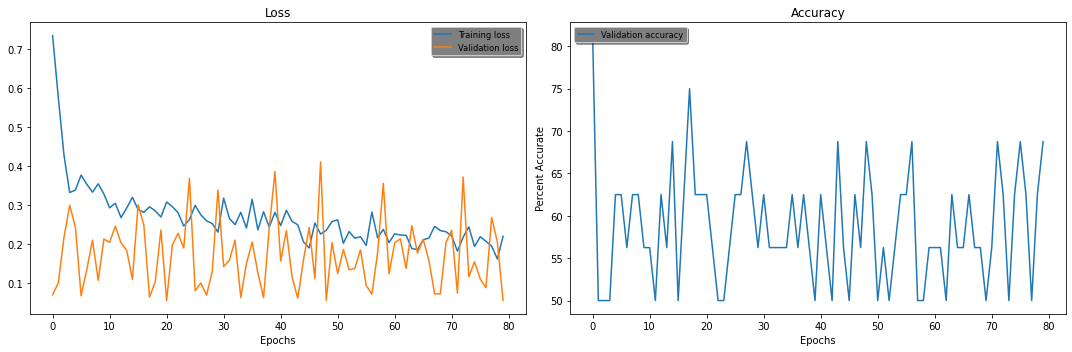

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
legend = plt.legend(loc='upper right', shadow=True, fontsize='small')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C7')

plt.subplot(1, 2, 2)
plt.plot(validation_accuracy, label='Validation accuracy')
plt.title('Accuracy')
plt.ylabel('Percent Accurate')
plt.xlabel('Epochs')
legend = plt.legend(loc='upper left', shadow=True, fontsize='small')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C7')
plt.tight_layout()

# Test Model

In [19]:
test_correct, test_total, test_loss = model.check_neural_network_accuracy(test_loader, device, loss_function)
print("Test Loss: {:.3f}".format(test_loss), " - Test Accuracy: %d%%" % ((test_correct / test_total) * 100)) 

Checking accuracy:
Test Loss: 3.557  - Test Accuracy: 85%


In [21]:
train_correct, train_total, train_loss = model.check_neural_network_accuracy(train_loader, device, loss_function)
print("Train Loss: {:.3f}".format(train_loss), " - Train Accuracy: %d%%" % ((train_correct / train_total) * 100))


Train Loss: 23.341  - Train Accuracy: 87%


# Save Model

In [25]:
torch.save(model.state_dict(), 'output/x-ray.pat')

# Load Model

In [26]:
model = Chest_XRay()
model.load_state_dict(torch.load('output/x-ray.pat'))
model.eval()

Chest_XRay(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (2_5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5_5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8_5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
   

# Test After Load

In [27]:
test_correct, test_total, test_loss = model.check_neural_network_accuracy(test_loader, device, loss_function)
print("Test Loss: {:.3f}".format(test_loss), " - Test Accuracy: %d%%" % ((test_correct / test_total) * 100)) 

Checking accuracy:
Test Loss: 3.623  - Test Accuracy: 85%
